## ME 334: Advanced Dynamics, Control and System Identification
### Stanford University

In [1]:
# imports
import numpy as np
import sympy as sp
from sympy import *
from sympy.vector import *
init_printing(use_unicode=True)


import matplotlib.pyplot as plt  #This is used for static graphs
from mpl_toolkits.mplot3d import Axes3D
import mpl_toolkits.mplot3d.axes3d as p3

## Setup

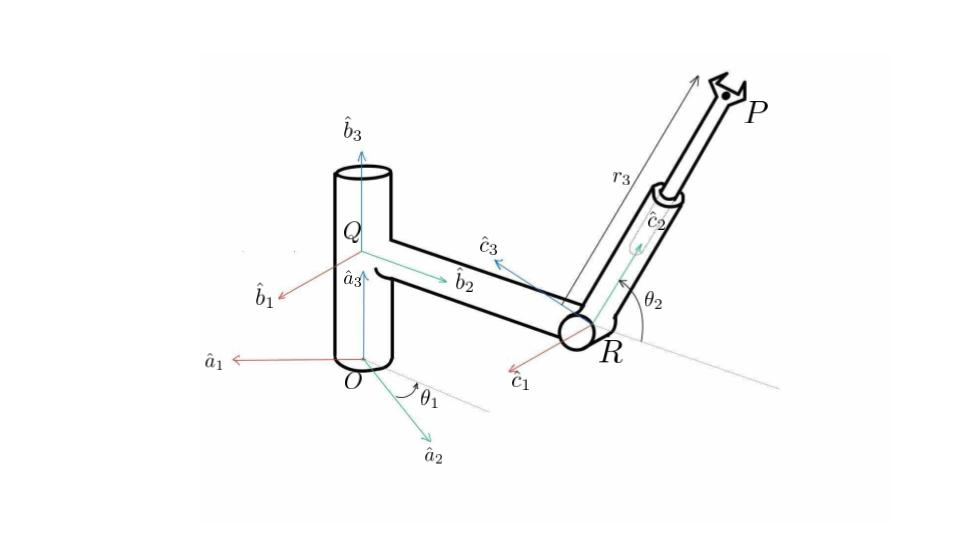

In [28]:
# defining free parameters
th1 = symbols(r'\theta_1')  # variables
th2 = symbols(r'\theta_2')
r3 = symbols(r'r_3')
dth1 = symbols(r'\dot{\theta}_1')  # first derivatives
dth2 = symbols(r'\dot{\theta}_2')
dr3 = symbols(r'\dot{r}_3')
ddth1 = symbols(r'\ddot{\theta}_1')  # second derivatives
ddth2 = symbols(r'\ddot{\theta}_2')
ddr3 = symbols(r'\ddot{r}_3')

In [29]:
## functions for kinematics
def rot_z(theta):
    R = Matrix([
        [sp.cos(theta), -sp.sin(theta), 0],
        [sp.sin(theta), sp.cos(theta), 0],
        [0, 0, 1],
    ])
    return R

def rot_y(theta):
    R = Matrix([
        [sp.cos(theta), 0, sp.sin(theta)],
        [0,1,0],
        [-sp.sin(theta),0, sp.cos(theta)],
    ])
    return R

def rot_x(theta):
    R = Matrix([
        [1, 0, 0],
        [0, sp.cos(theta), -sp.sin(theta)],
        [0, sp.sin(theta), sp.cos(theta)],
    ])
    return R

In [30]:
## frames and joint variables
R_AB = rot_z(th1)
R_BC = rot_x(th2)

In [31]:
## link geometry
# link 1
H1v = 0.200 
H1h = 0.300
R1v = 0.025
R1h = 0.0175

# link 2
H2 = 0.250
R2i = 0.006
R2e = 0.012

# link 3
H3 = 0.250
R3 = 0.0055

## density of aluminum
rho = 2700

## kinematic params
L1 = 0.130 #OQ
L2 = H1h #QR

First, we compute the locations of the centers of mass of each link.

In [32]:
def mass_cylinder(R, H, rho):
    return np.pi * R ** 2 * H * rho

mv = mass_cylinder(R1v, H1v, rho)
mh = mass_cylinder(R1h, H1h, rho)
m1 = mv + mh
m2 = mass_cylinder(R2e, H2, rho) - mass_cylinder(R2i, H2, rho)
m3 = mass_cylinder(R3, H3, rho)

m1, m2, m3

C:\Users\pwu154371\Miniconda3\envs\me334\lib\site-packages\IPython\lib\latextools.py:126: MatplotlibDeprecationWarning: 
The to_png function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use mathtext.math_to_image instead.
  mt.to_png(f, s, fontsize=12, dpi=dpi, color=color)
C:\Users\pwu154371\Miniconda3\envs\me334\lib\site-packages\IPython\lib\latextools.py:126: MatplotlibDeprecationWarning: 
The to_rgba function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use mathtext.math_to_image instead.
  mt.to_png(f, s, fontsize=12, dpi=dpi, color=color)
C:\Users\pwu154371\Miniconda3\envs\me334\lib\site-packages\IPython\lib\latextools.py:126: MatplotlibDeprecationWarning: 
The to_mask function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use mathtext.math_to_image instead.
  mt.to_png(f, s, fontsize=12, dpi=dpi, color=color)
C:\Users\pwu154371\Miniconda3\envs\me334\lib\site-packages\IPython\lib\

In [33]:
# location of P1 (COM 1)
mv = np.pi * (R1v ** 2) * H1v * rho  # vertical mass
mh = np.pi * (R1h ** 2) * H1h * rho  # horizontal mass
locv = Matrix([[0], [0], [H1v / 2]])  # vertical location, A frame
loch = Matrix([[-(H1h / 2) * sin(th1)], [(H1h / 2) * cos(th1)], [L1]])  # horizontal location, A frame
A_r_OP1 = (mv * locv + mh * loch) / (mv + mh)

# location of P2 (COM2)
C_r_RP2 = Matrix([[0], [H2/2], [0]])  # location 2, C frame
B_r_QP2 = R_BC * C_r_RP2 + Matrix([[0], [L2], [0]])  # transform to B frame
A_r_OP2 = R_AB * B_r_QP2 + Matrix([[0], [0], [L1]])  # transform to A frame


# location of P3 (COM3)
C_r_RP3 = Matrix([[0], [r3-H3/2], [0]])  # location 2, C frame
B_r_QP3 = R_BC * C_r_RP3 + Matrix([[0], [L2], [0]]) # transform to B frame
A_r_OP3 = R_AB * B_r_QP3 + Matrix([[0], [0], [L1]])  # transform to A frame

A_r_OP3

⎡-((r₃ - 0.125)⋅cos(\theta₂) + 0.3)⋅sin(\theta₁)⎤
⎢                                               ⎥
⎢((r₃ - 0.125)⋅cos(\theta₂) + 0.3)⋅cos(\theta₁) ⎥
⎢                                               ⎥
⎣       (r₃ - 0.125)⋅sin(\theta₂) + 0.13        ⎦

Second, we compute the velocities of the centers of mass of each link.

In [8]:
#angular velocities
A_w_AB = dth1 * Matrix([[0], [0], [1]])
A_w_BC = R_AB * (R_BC * (dth2 * Matrix([[1], [0], [0]])))
A_w_AC = A_w_AB + A_w_BC

In [34]:
# computing A_v_AP1 - no translational velocity
A_v_AP1 = A_w_AB.cross(A_r_OP1)  # note: B_w_AB = A_w_AB

# computing A_v_AP2
A_v_AP2 = sp.simplify(A_w_AB.cross(A_r_OP2) + A_w_BC.cross(R_AB * (R_BC * C_r_RP2)))


# computing A_v_AP3
A_v_AP3 = sp.simplify(
    A_w_AB.cross(A_r_OP3)
    + A_w_BC.cross(R_AB * (R_BC * C_r_RP3))
    + R_AB * (R_BC * (dr3 * Matrix([[0], [1], [0]])))
)

In [38]:
A_w_AB.cross(A_r_OP2)

⎡-\dot{\theta}₁⋅(0.125⋅cos(\theta₂) + 0.3)⋅cos(\theta₁)⎤
⎢                                                      ⎥
⎢-\dot{\theta}₁⋅(0.125⋅cos(\theta₂) + 0.3)⋅sin(\theta₁)⎥
⎢                                                      ⎥
⎣                          0                           ⎦

In [37]:
A_w_BC

⎡\dot{\theta}₂⋅cos(\theta₁)⎤
⎢                          ⎥
⎢\dot{\theta}₂⋅sin(\theta₁)⎥
⎢                          ⎥
⎣            0             ⎦

In [36]:
R_AB * (R_BC * C_r_RP2)

⎡-0.125⋅sin(\theta₁)⋅cos(\theta₂)⎤
⎢                                ⎥
⎢0.125⋅cos(\theta₁)⋅cos(\theta₂) ⎥
⎢                                ⎥
⎣       0.125⋅sin(\theta₂)       ⎦

In [35]:
A_v_AP2

⎡-\dot{\theta}₁⋅(0.125⋅cos(\theta₂) + 0.3)⋅cos(\theta₁) + 0.125⋅\dot{\theta}₂⋅
⎢                                                                             
⎢-\dot{\theta}₁⋅(0.125⋅cos(\theta₂) + 0.3)⋅sin(\theta₁) - 0.125⋅\dot{\theta}₂⋅
⎢                                                                             
⎣                                   0.125⋅\dot{\theta}₂⋅cos(\theta₂)          

sin(\theta₁)⋅sin(\theta₂)⎤
                         ⎥
sin(\theta₂)⋅cos(\theta₁)⎥
                         ⎥
                         ⎦

Third, we express the angular velocities of each link in convenient frames for the energy calculation.

In [10]:
# compute these directly from the frames of interest

# angular velocity of link 1 in frame B
B_w_AB = R_AB.transpose() * A_w_AB  # note: B_w_AB = A_w_AB

# angular velocity of link 2, 3 in frame C
C_w_BC = (R_AB * R_BC).transpose() * A_w_BC
C_w_AC = (R_AB * R_BC).transpose() * A_w_AC

# the angular velocities of links 2 and 3 are identical as they only translate wrt each other

Fourth, we compute the inertia tensors of each link. Following the integration procedure here: https://scienceworld.wolfram.com/physics/MomentofInertiaCylinder.html, we know that the inertia tensor of a solid cylinder is

In [11]:
def Ic_cylinder(R, H, rho):
    Ic = (np.pi * rho * R ** 2 * H) * Matrix([
        [(H ** 2) / 12 + (R ** 2) / 4, 0, 0], 
        [0, (H ** 2) / 12 + (R ** 2) / 4, 0],
        [0, 0, (R ** 2) / 2],
    ])
    return Ic

def inertia_particle(p1, p2):
    x = p1[0] - p2[0]
    y = p1[1] - p2[1]
    z = p1[2] - p2[2]
    I = Matrix([
        [y ** 2 + z ** 2, -x * y, -x * z],
        [-x * y, x ** 2 + z ** 2, -y * z],
        [-x * z, -y * z, x ** 2 + y ** 2],
    ])
    return I

In [12]:
# inertia of link 1 about its center of mass in SRT B
I_hrz = Ic_cylinder(R1h, H1h, rho) # inertia of horizontal segment expressed in a frame with horizontal z axis 
I_vert = Ic_cylinder(R1v, H1v, rho) # inertia of vertical segment expressed in a frame with vertical z axis
# as there is axial symmetry, x and y axes are non-unique, any rotation about z doesn't change the inertia tensor
rot_perp = rot_x(np.pi / 2) #rotation of pi/2 about x
I_hrz_rot = rot_perp * I_hrz * rot_perp.transpose()

# shifting theorem to get inertia tensors of both parts about mass center of link 1 in frame B
I_hrz_cen = I_hrz_rot + mh * inertia_particle(loch.subs(th1, 0), A_r_OP1.subs(th1, 0))  #inertia of horizontal segment about mass center of link 1 
I_vert_cen = I_vert + mv * inertia_particle(locv.subs(th1, 0), A_r_OP1.subs(th1, 0)) #inertia of vertical segment about mass center of link 1
B_I1 = I_hrz_cen + I_vert_cen

# inertia of link 2 about its center of mass in frame C: this time for the external and internal, point of reference and frame are both already same in the formula
C_I2 = rot_perp.transpose() * (Ic_cylinder(R2e, H2, rho) - Ic_cylinder(R2i, H2, rho)) * rot_perp #originally the z axis was along c2, so we rotate about c1 by -pi/2

#  inertia of link 3 about its center of mass in frame C
C_I3 = rot_perp.transpose() * (Ic_cylinder(R3, H3, rho)) * rot_perp

Finally, we compute the total kinetic energy of the system. 

Note that inertias and angular velocities can be expressed in any SRT, but the inertia tensor for any particular link and its angular velocity have to expressed in the same SRT for the energy term to make sense.

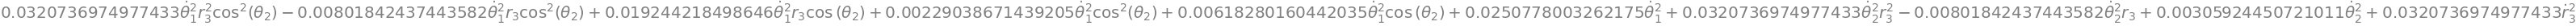

In [13]:
T_mat_form = (1 / 2) * (
    m1 * A_v_AP1.transpose() * A_v_AP1
    + m2 * A_v_AP2.transpose() * A_v_AP2
    + m3 * A_v_AP3.transpose() * A_v_AP3
    + B_w_AB.transpose() * B_I1 * B_w_AB
    + C_w_BC.transpose() * (C_I2 + C_I3) * C_w_BC
)
T = sp.simplify(T_mat_form[0])
T

At the given state, in Nm, the kinetic energy is:

In [14]:
# acceleration due to gravity 
g = 98/10

In [15]:
# potential energy
V = m1*g*A_r_OP1[2] + m2*g*A_r_OP2[2] + m3*g*A_r_OP3[2]
V

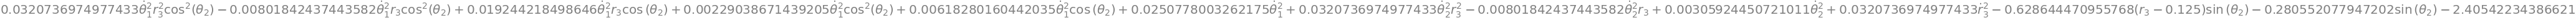

In [16]:
# Lagrangian
L = T-V
L

In [17]:
#introduce time as a variable

t = symbols('t')
q1 = Function('q1')(t) #position
dq1 = Function('dq1')(t) #velocity
ddq1 = Function('ddq1')(t) #acceleration
q2 = Function('q2')(t) #position
dq2 = Function('dq2')(t) #velocity
ddq2 = Function('ddq2')(t) #acceleration
q3 = Function('q3')(t) #position
dq3 = Function('dq3')(t) #velocity
ddq3 = Function('ddq3')(t) #acceleration


Lag = L.subs([(th1, q1), (dth1, dq1), (th2, q2), (dth2, dq2), (r3, q3), (dr3, dq3)])


def derive_eom(Lag, q, dq, ddq):
    eq0 = (diff(diff(Lag, dq), t) - diff(Lag, q)) #derive the Lagrangian EOMs left hand side, this equals the external non-conservative force
    eq  = eq0.subs([(diff(dq1, t), ddq1), (diff(q2, t), dq2), (diff(dq2, t), ddq2), (diff(q3, t), dq3), (diff(dq3, t), ddq3)])
    return eq

eq1 = derive_eom(Lag, q1, dq1, ddq1)
eq2 = derive_eom(Lag, q2, dq2, ddq2)
eq3 = derive_eom(Lag, q3, dq3, ddq3)

eq = Matrix([[eq1], [eq2], [eq3]])

In [18]:
tau1_func = sp.lambdify((q1, q2, q3, dq1, dq2, dq3, ddq1, ddq2, ddq3), eq[0]) #numerical implementation of LHS as a fn of generalized coordinates, speeds, accelerations
tau2_func = sp.lambdify((q1, q2, q3, dq1, dq2, dq3, ddq1, ddq2, ddq3), eq[1])
f3_func = sp.lambdify((q1, q2, q3, dq1, dq2, dq3, ddq1, ddq2, ddq3), eq[2])

In [19]:
t_vals = np.linspace(0,10,1000) #discretize the time interval into 100 instants

dq1_des, ddq1_des, dq2_des, ddq2_des, dq3_des, ddq3_des = symbols('dq1_des ddq1_des dq2_des ddq2_des dq3_des ddq3_des')

q1_des = -sqrt(2)*sin(2*t+np.pi/7) #desired position
q2_des = sqrt(3)*cos(3*t/10)
q3_des = (sqrt(5)*sin(t)+sqrt(11))/1000

dq1_des = diff(q1_des, t) #desired velocity
dq2_des = diff(q2_des, t)
dq3_des = diff(q3_des, t)

ddq1_des = diff(dq1_des, t) #desired acceleration
ddq2_des = diff(dq2_des, t)
ddq3_des = diff(dq3_des, t)

Matrix([[q1_des, dq1_des, ddq1_des],
[q2_des, dq2_des, ddq2_des],
[q3_des, dq3_des, ddq3_des]])

C:\Users\pwu154371\Miniconda3\envs\me334\lib\site-packages\IPython\lib\latextools.py:126: MatplotlibDeprecationWarning: 
The to_png function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use mathtext.math_to_image instead.
  mt.to_png(f, s, fontsize=12, dpi=dpi, color=color)
C:\Users\pwu154371\Miniconda3\envs\me334\lib\site-packages\IPython\lib\latextools.py:126: MatplotlibDeprecationWarning: 
The to_rgba function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use mathtext.math_to_image instead.
  mt.to_png(f, s, fontsize=12, dpi=dpi, color=color)
C:\Users\pwu154371\Miniconda3\envs\me334\lib\site-packages\IPython\lib\latextools.py:126: MatplotlibDeprecationWarning: 
The to_mask function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use mathtext.math_to_image instead.
  mt.to_png(f, s, fontsize=12, dpi=dpi, color=color)
C:\Users\pwu154371\Miniconda3\envs\me334\lib\site-packages\IPython\lib\

⎡-√2⋅sin(2⋅t + 0.448798950512828)  -2⋅√2⋅cos(2⋅t + 0.448798950512828)  4⋅√2⋅si
⎢                                                                             
⎢                                                    ⎛3⋅t⎞                    
⎢                                           -3⋅√3⋅sin⎜───⎟                    
⎢                ⎛3⋅t⎞                               ⎝ 10⎠                    
⎢          √3⋅cos⎜───⎟                      ───────────────                   
⎢                ⎝ 10⎠                             10                         
⎢                                                                             
⎢        √5⋅sin(t)   √11                       √5⋅cos(t)                      
⎢        ───────── + ────                      ─────────                      
⎣           1000     1000                         1000                        

n(2⋅t + 0.448798950512828)⎤
                          ⎥
           ⎛3⋅t⎞          ⎥
  -9⋅√3⋅cos⎜───⎟          ⎥
           ⎝ 10⎠  

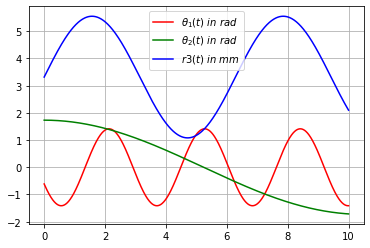

In [20]:
#position values at time instants
q1_func = sp.lambdify(t, q1_des)
q1_vals = q1_func(t_vals) 
q2_func = sp.lambdify(t, q2_des)
q2_vals = q2_func(t_vals) 
q3_func = sp.lambdify(t, q3_des)
q3_vals = q3_func(t_vals) 

#velocity values at time instants
dq1_func = sp.lambdify(t, dq1_des)
dq1_vals = dq1_func(t_vals) 
dq2_func = sp.lambdify(t, dq2_des)
dq2_vals = dq2_func(t_vals) 
dq3_func = sp.lambdify(t, dq3_des)
dq3_vals = dq3_func(t_vals) 

#acceleration values at time instants
ddq1_func = sp.lambdify(t, ddq1_des)
ddq1_vals = ddq1_func(t_vals) 
ddq2_func = sp.lambdify(t, ddq2_des)
ddq2_vals = ddq2_func(t_vals) 
ddq3_func = sp.lambdify(t, ddq3_des)
ddq3_vals = ddq3_func(t_vals) 


fig = plt.figure()
ax = fig.add_subplot(111, autoscale_on=True) #if you want to strictly set the bounds
ax.grid() #this allows us to see the grid
ax.plot(t_vals,q1_vals,'r',label='$\\theta_1(t)~in~rad$') #Note: when using latex in legends, use double instead of single '\' for variables
ax.plot(t_vals,q2_vals,'g',label='$\\theta_2(t)~in~rad$')
ax.plot(t_vals,1000*q3_vals,'b',label='$r3(t)~in~mm$')
ax.legend() #show the legend

plt.show() #this says display the info here

In [21]:
#generalized forces
tau1_vals = tau1_func(q1_vals, q2_vals, q3_vals, dq1_vals, dq2_vals, dq3_vals, ddq1_vals, ddq2_vals, ddq3_vals) #force values at time instants
tau2_vals = tau2_func(q1_vals, q2_vals, q3_vals, dq1_vals, dq2_vals, dq3_vals, ddq1_vals, ddq2_vals, ddq3_vals)
f3_vals = f3_func(q1_vals, q2_vals, q3_vals, dq1_vals, dq2_vals, dq3_vals, ddq1_vals, ddq2_vals, ddq3_vals)

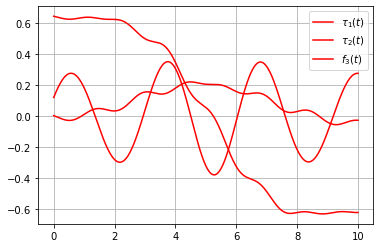

In [22]:
fig = plt.figure()
ax = fig.add_subplot(111, autoscale_on=True) #if you want to strictly set the bounds
ax.grid() #this allows us to see the grid
ax.plot(t_vals, tau1_vals,'r',label='$\\tau_1(t)$') #Note: when using latex in legends, use double instead of single '\' for variables
ax.plot(t_vals, tau2_vals,'r',label='$\\tau_2(t)$')
ax.plot(t_vals, f3_vals,'r',label='$f_3(t)$')
ax.legend() #show the legend

plt.show() #this says display the info here

In [23]:
# rewrite energy explicitly as function of time
E = (T+V).subs([(th1, q1), (dth1, dq1), (th2, q2), (dth2, dq2), (r3, q3), (dr3, dq3)])

 #rate of change of total energy written in terms of q, dq, ddq
dE = diff(E, t).subs([(diff(dq1, t), ddq1), (diff(q2, t), dq2), (diff(dq2, t), ddq2), (diff(q3, t), dq3), (diff(dq3, t), ddq3)])
dE

C:\Users\pwu154371\Miniconda3\envs\me334\lib\site-packages\IPython\lib\latextools.py:126: MatplotlibDeprecationWarning: 
The to_png function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use mathtext.math_to_image instead.
  mt.to_png(f, s, fontsize=12, dpi=dpi, color=color)
C:\Users\pwu154371\Miniconda3\envs\me334\lib\site-packages\IPython\lib\latextools.py:126: MatplotlibDeprecationWarning: 
The to_rgba function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use mathtext.math_to_image instead.
  mt.to_png(f, s, fontsize=12, dpi=dpi, color=color)
C:\Users\pwu154371\Miniconda3\envs\me334\lib\site-packages\IPython\lib\latextools.py:126: MatplotlibDeprecationWarning: 
The to_mask function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use mathtext.math_to_image instead.
  mt.to_png(f, s, fontsize=12, dpi=dpi, color=color)
C:\Users\pwu154371\Miniconda3\envs\me334\lib\site-packages\IPython\lib\

In [24]:
dE_func = sp.lambdify((q1, q2, q3, dq1, dq2, dq3, ddq1, ddq2, ddq3), dE) #numerical implementation to calculate rate of change of energy as fn of y, vy, ay
dE_vals = dE_func(q1_vals, q2_vals, q3_vals, dq1_vals, dq2_vals, dq3_vals, ddq1_vals, ddq2_vals, ddq3_vals)

In [25]:
power_vals = tau1_vals*dq1_vals +tau2_vals*dq2_vals +f3_vals*dq3_vals - dE_vals #power delivered minus energy increase rate

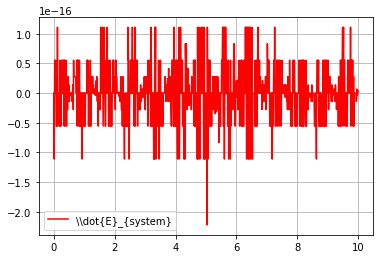

In [26]:
### Energy conservation check 

fig = plt.figure()
ax = fig.add_subplot(111, autoscale_on=True) #if you want to strictly set the bounds
ax.grid() #this allows us to see the grid
ax.plot(t_vals,power_vals,'r',label='$\\dot{E}_{system}$') #Note: when using latex in legends, use double instead of single '\' for variables
ax.legend() #show the legend

plt.show() #this says display the info here